# Loading in Packages

In [1]:
library(tidyverse)
library(rjson)
library(here)
library(png)
library(hablar)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.0     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.1     ✔ tibble    3.1.8
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
here() starts at /kaggle/working


Attaching package: ‘hablar’


The following object is masked from ‘package:forcats’:

    fct


The following object is masked from ‘package:dplyr’:

    na_if


The following object is masked from ‘package:tibble’:

    num




# Loading in Data

In [2]:
training_data <- read.csv(file='/kaggle/input/fathomnet-out-of-sample-detection/multilabel_classification/train.csv')
key <- read.csv(file='/kaggle/input/fathomnet-out-of-sample-detection/category_key.csv')
sample <- read.csv(file='/kaggle/input/fathomnet-out-of-sample-detection/sample_submission.csv')
train.json <- fromJSON(file="/kaggle/input/fathomnet-out-of-sample-detection/object_detection/train.json")
eval.json <- fromJSON(file="/kaggle/input/fathomnet-out-of-sample-detection/object_detection/eval.json")

In [3]:
images.train.json <- data.frame(do.call(rbind,train.json[["images"]])) %>% convert(num(id, width,height,license), chr(file_name,flickr_url,coco_url,date_captured))
cat.train.json <- as.data.frame(do.call(rbind,train.json[["categories"]])) %>% convert(num(id), chr(name, supercategory))
images.eval.json <- as.data.frame(do.call(rbind,eval.json[["images"]])) %>% convert(num(id, width,height,license), chr(file_name,flickr_url,coco_url,date_captured))

# EDA

Exploring the categories and supercategories

In [7]:
head(key)

id name          supercat
1 1  Actiniaria    Anemone 
2 2  Actinernus    Anemone 
3 3  Actiniidae    Anemone 
4 4  Actinoscyphia Anemone 
5 5  Bolocera      Anemone 
6 6  Dofleinia     Anemone

In [8]:
library(dplyr)
library(cowplot)
library(ggplot2)


Attaching package: ‘cowplot’


The following object is masked from ‘package:lubridate’:

    stamp




More challenging multilabel classification for Fish, Sea Star and Glass Sponge. It would be good to prepare more data to ensure that each label has sufficient data points to improve classification. This can be done with data augmentation.

* Horizontal Flip
* Random Rotate and Random Dihedral
* Hue, Saturation, Contrast, Brightness, Crop
* Colour jitter

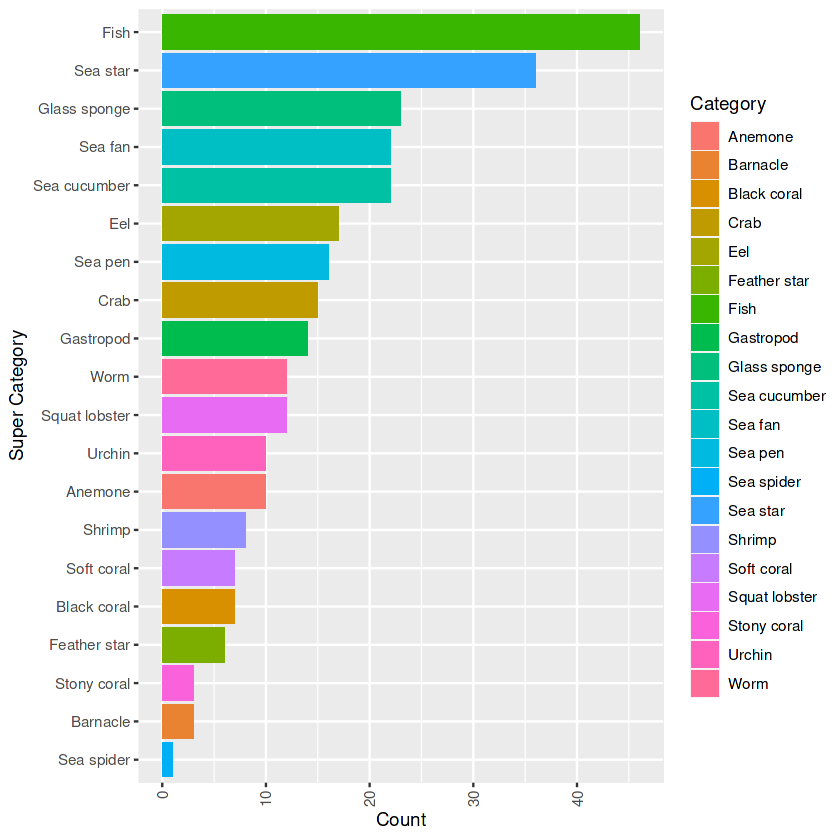

In [9]:
count_table <- table(key$supercat)

# Convert the count table to a dataframe and sort by count in descending order
count_df <- data.frame(Category = names(count_table), Count = as.numeric(count_table))
count_df <- count_df[order(-count_df$Count),]

# Create the bar plot with ggplot2
ggplot(count_df, aes(x = reorder(Category, Count), y = Count, fill = Category)) +
  geom_bar(stat = "identity") +
  labs(x = "Super Category", y = "Count") +
  coord_flip() +
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

## EDA on training data for multilabel classification

What is the distribution of labels amongst the images?

In [10]:
head(training_data)

id                                   categories              
1 3b6f01ae-5bde-434d-9b06-79b269421ed6 [1.0]                   
2 dce21f7c-20e5-482b-bd90-c038f8464c03 [1.0]                   
3 4a7f2199-772d-486d-b8e2-b651246316b5 [1.0]                   
4 3bddedf6-4ff8-4e81-876a-564d2b03b364 [1.0, 9.0, 11.0, 88.0]  
5 3f735021-f5de-4168-b139-74bf2859d12a [1.0, 37.0, 51.0, 119.0]
6 130e185f-09c5-490c-8d08-641c4cbf6e54 [1.0, 51.0, 119.0]

In [22]:
convert_str_to_list <- function(my_string) {
    # Remove the square brackets using the substring function
    my_string <- substring(my_string, 2, nchar(my_string)-1)

    # Split the string into a character vector
    my_vector <- strsplit(my_string, ", ")[[1]]

    # Convert the character vector to a numeric vector
    my_numeric_vector <- as.numeric(my_vector)

    return(my_numeric_vector)
}

label_dict <- setNames(key$name, key$id)

label_list <- c()
for (i in 1:nrow(training_data)) {
    list_cat <- convert_str_to_list(training_data[i, "categories"])
    temp <- list()
    for (id in list_cat) {
        temp <- append(temp, label_dict[id])
    }
    label_list <- c(label_list, temp)
}

label_list <- as.character(label_list)

The training data labels are very skewed. There is 1 species with a lot of labels (2500-3000) in the training data, but most are in the 0-500 range

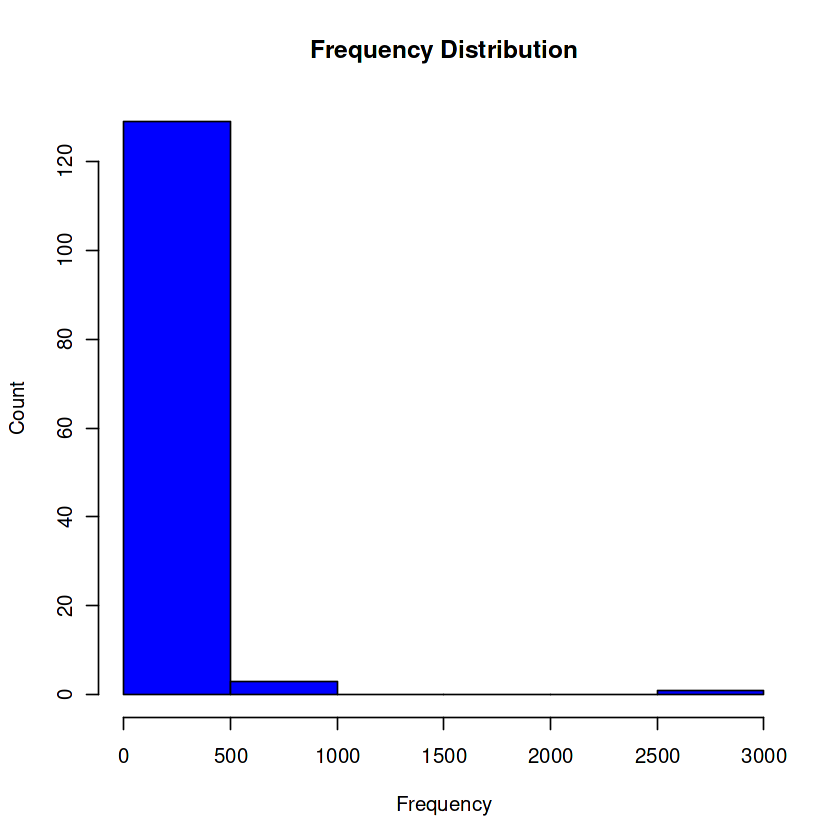

In [48]:
freq_df <- as.data.frame(table(label_list))
freq_df <- freq_df[order(freq_df$Freq),]
hist(freq_df$Freq, main = "Frequency Distribution", xlab = "Frequency", ylab = "Count", col = "blue")

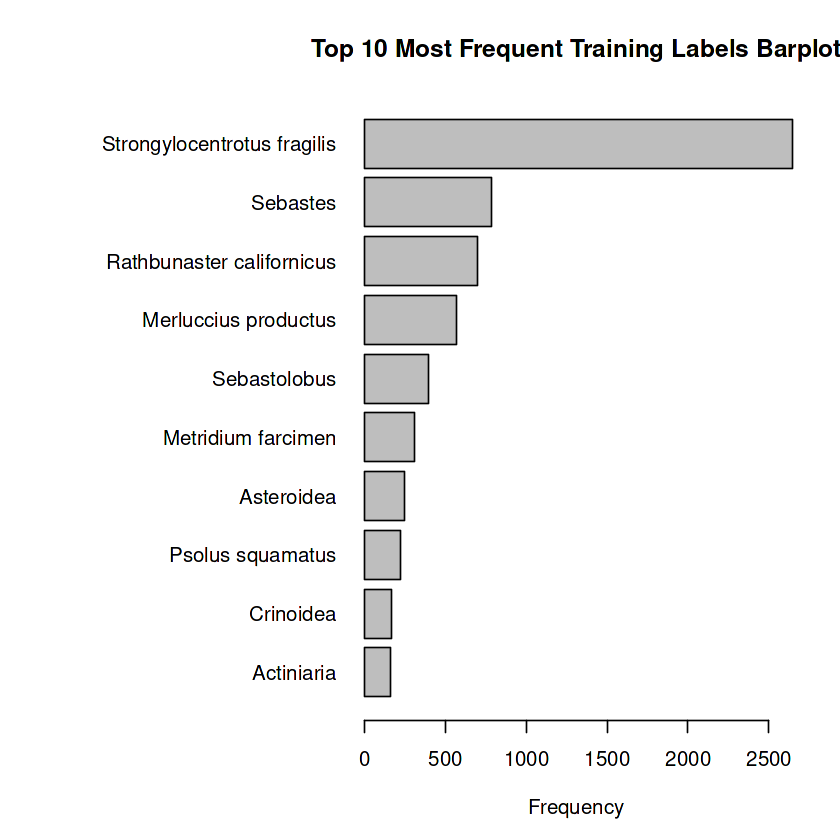

In [54]:
freq_df <- as.data.frame(table(label_list))
freq_df <- freq_df[order(freq_df$Freq),]
top_10 <- tail(freq_df, 10)
# to display data labels
par(mar = c(5, 15, 4, 2))
barplot(height = top_10$Freq, names.arg = top_10$label_list, main = "Top 10 Most Frequent Training Labels Barplot", xlab = "Frequency", horiz = TRUE, las = 1) 

In [123]:
#training_directory_path <- "/kaggle/working/trainingimages"
#evaluation_directory_path <- "/kaggle/working/evalimages"
#dir.create(training_directory_path)
#dir.create(evaluation_directory_path)

find_url_of_image_containing_id <- function(id, df) {
    for (i in 1:nrow(df)) {
        list_cat <- convert_str_to_list(df[i, "categories"])
        id_is_present <- id %in% list_cat
        if (id_is_present && length(list_cat) == 1) {
            url <- df[i, "flickr_url"]
            return(url)
        }
    }
}

download_images <- function(url, image_path) { 
    myurl <- paste(url, sep = "") 
    z <- tempfile()
    download.file(myurl,z,mode="wb")
    pic <- readPNG(z)
    writePNG(pic, image_path) 
    file.remove(z)
}

display_images <- function(image_path_list, title_text_list) {
    for (i in 1:length(image_path_list)) {
        image_path <- image_path_list[[i]]
        title_text <- title_text_list[[i]]
        pic <- readPNG(image_path,native=TRUE)
        par(mar = c(0,0,0,0)) # set margins to 0
        plot(0:1,0:1,type="n",ann=FALSE,axes=FALSE)
        # display the image
        plot.new()
        rasterImage(pic,0,0,1,1)
        # add the title
        text(x = 0.5, y = 0.95, title_text, col="white", cex = 1.2, font=2)
    }
}

In [ ]:
images.train.json["image_id"] <- str_sub(images.train.json$file_name, start = 1, end = -5)
training_data_merged = inner_join(training_data, images.train.json, by=c('id'='image_id'))
head(training_data_merged)

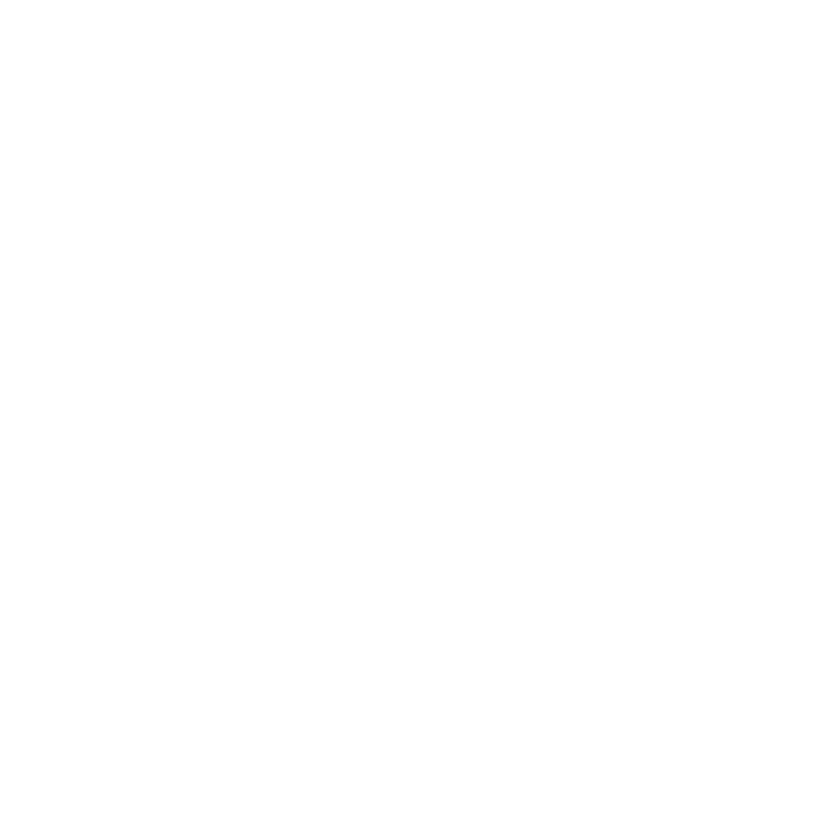

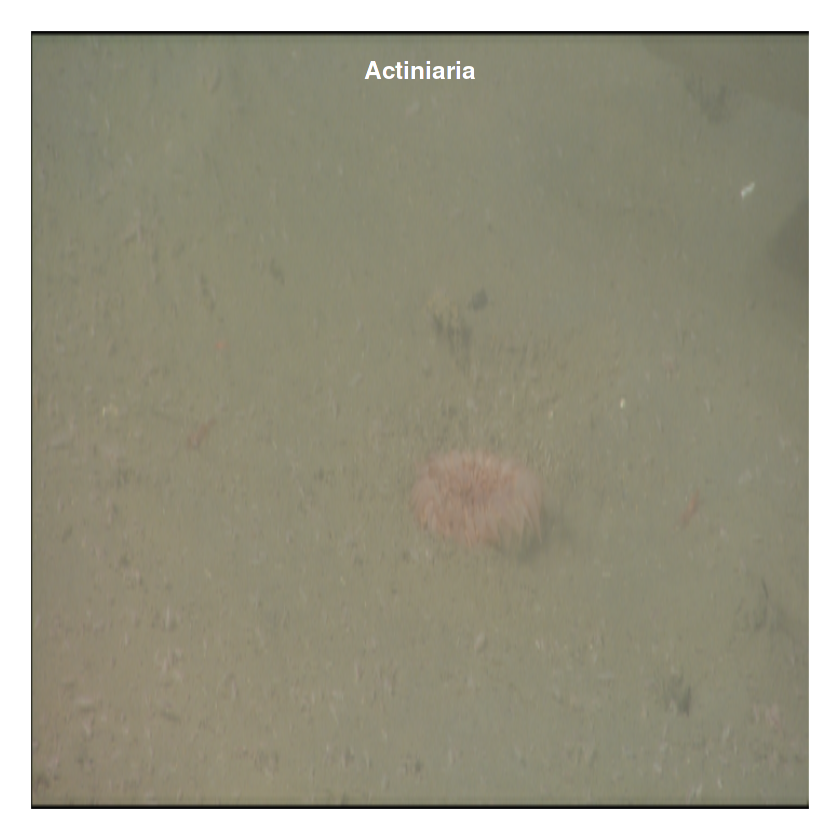

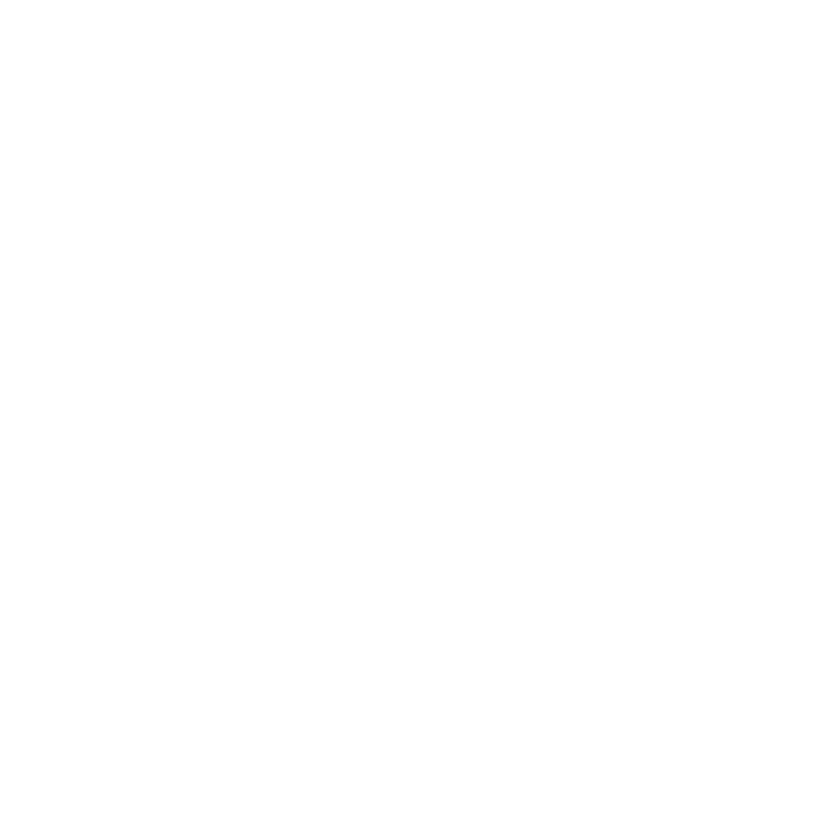

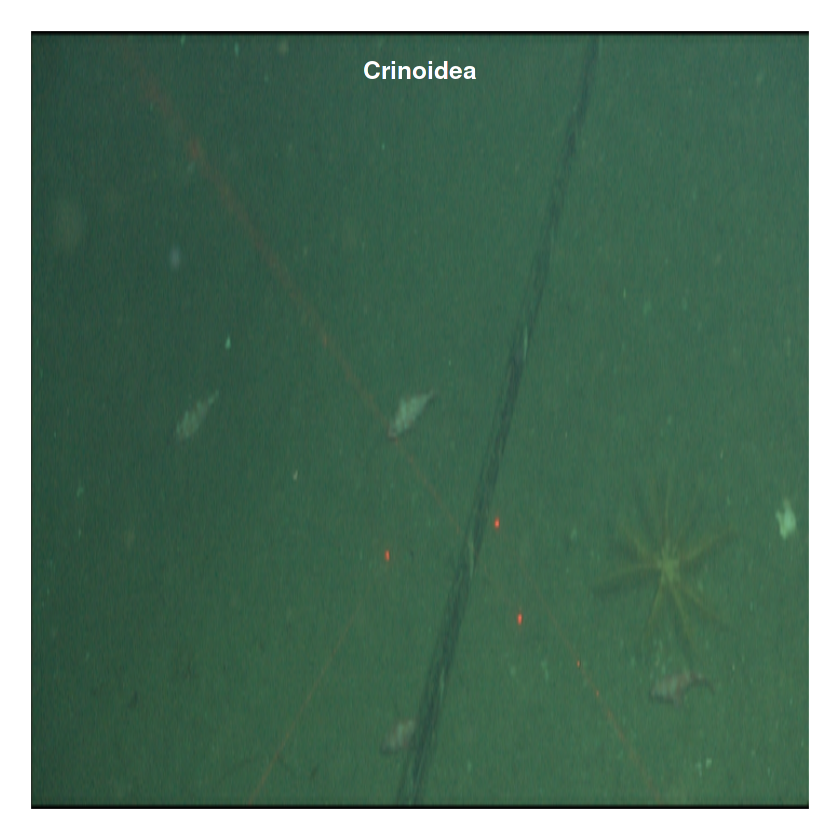

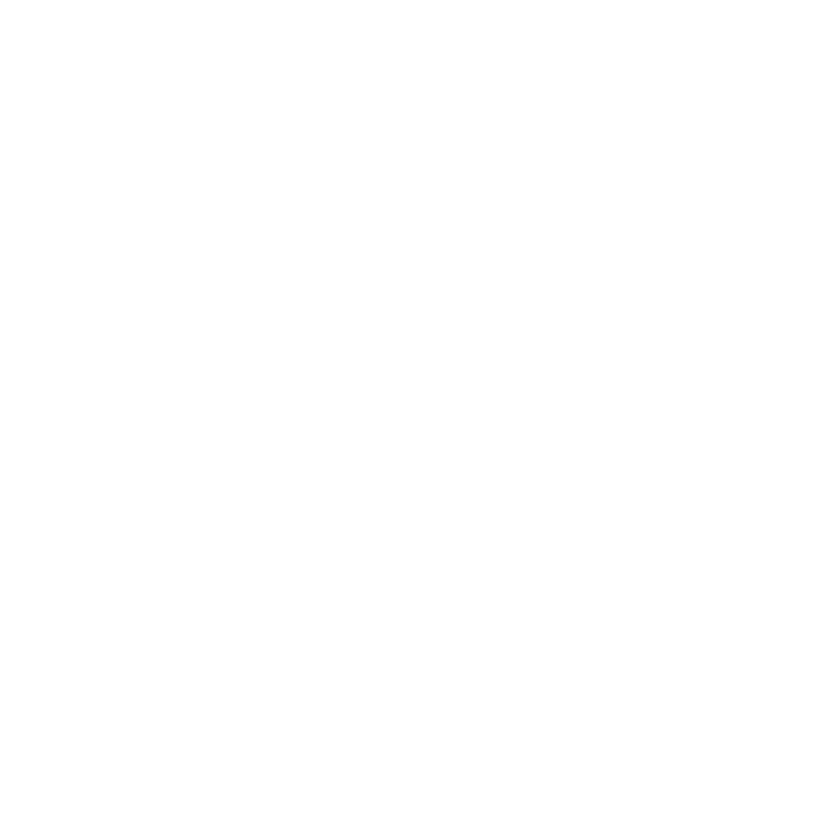

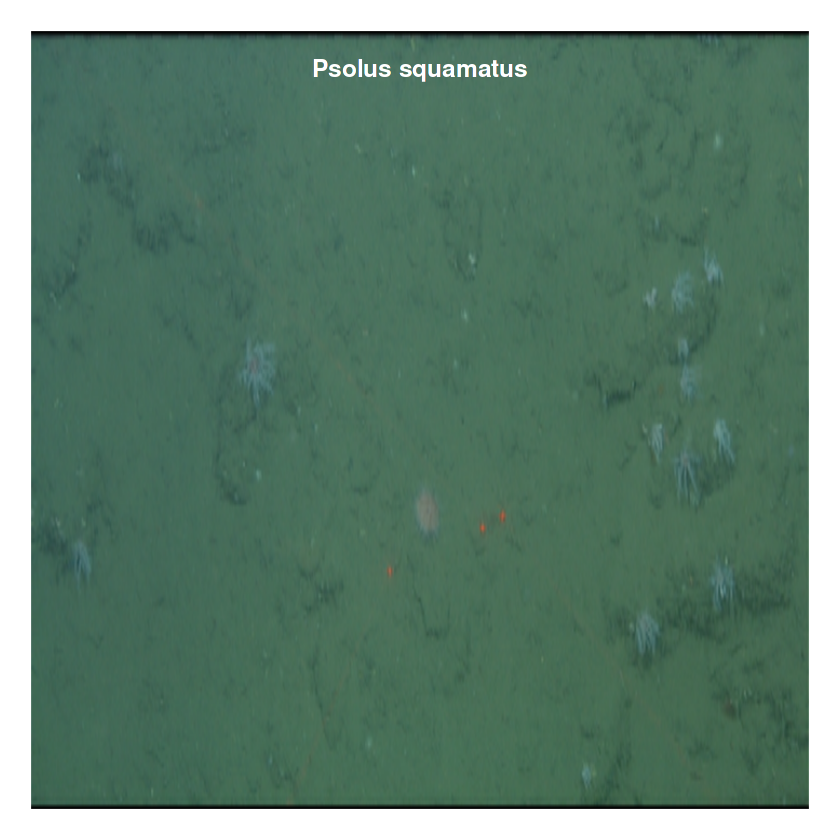

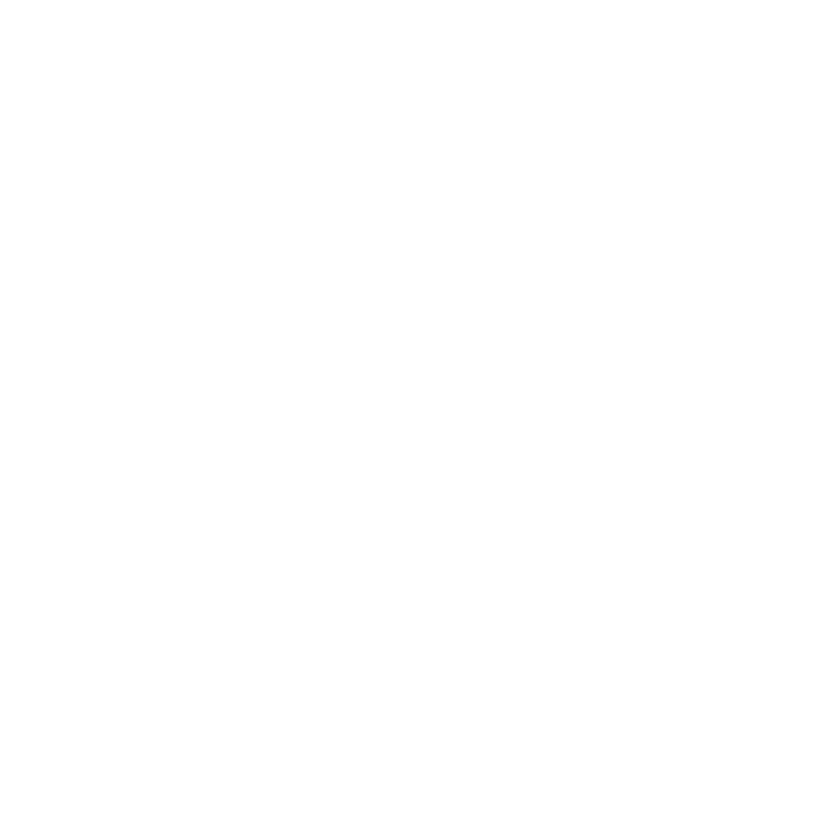

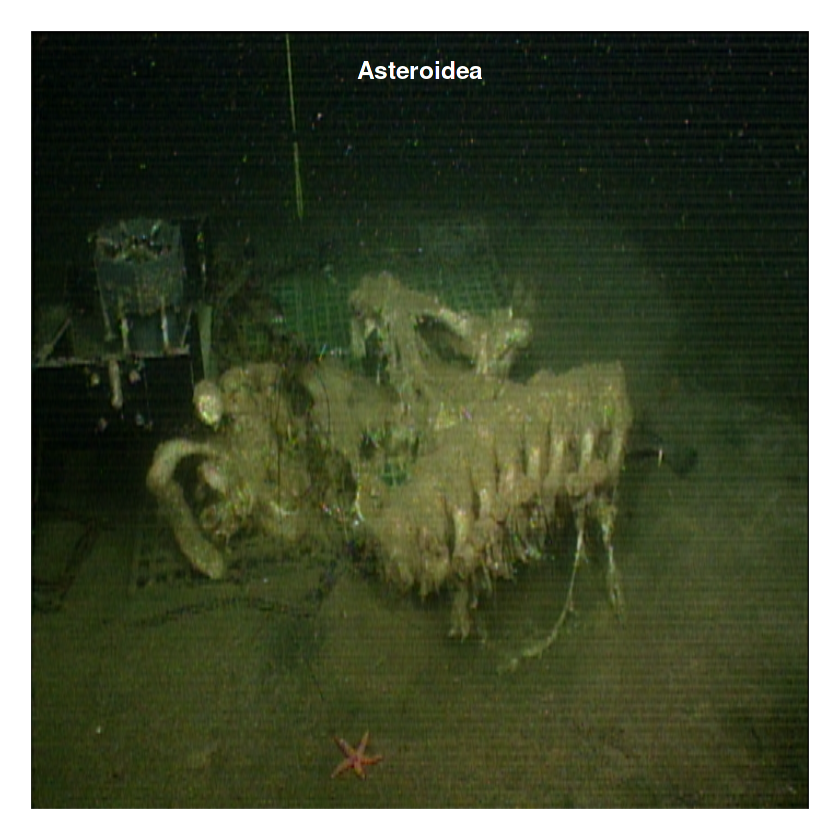

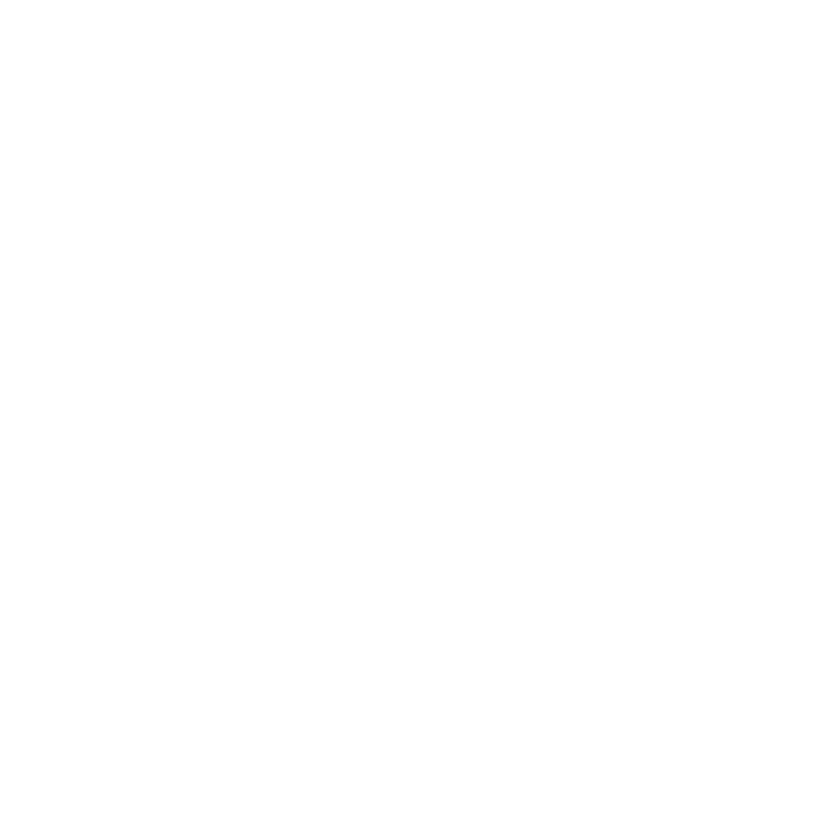

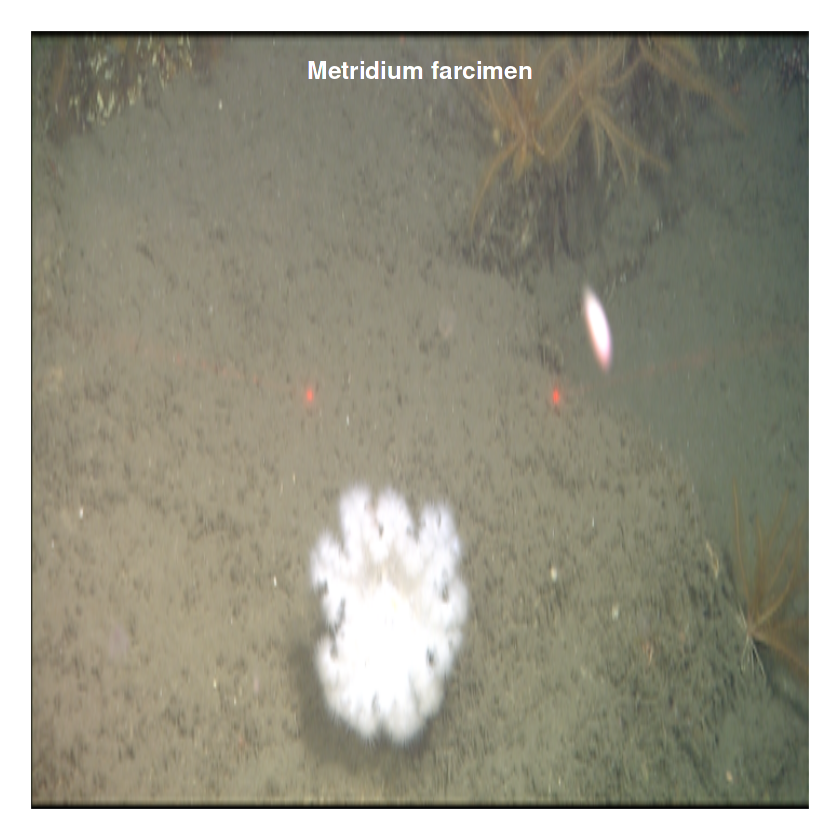

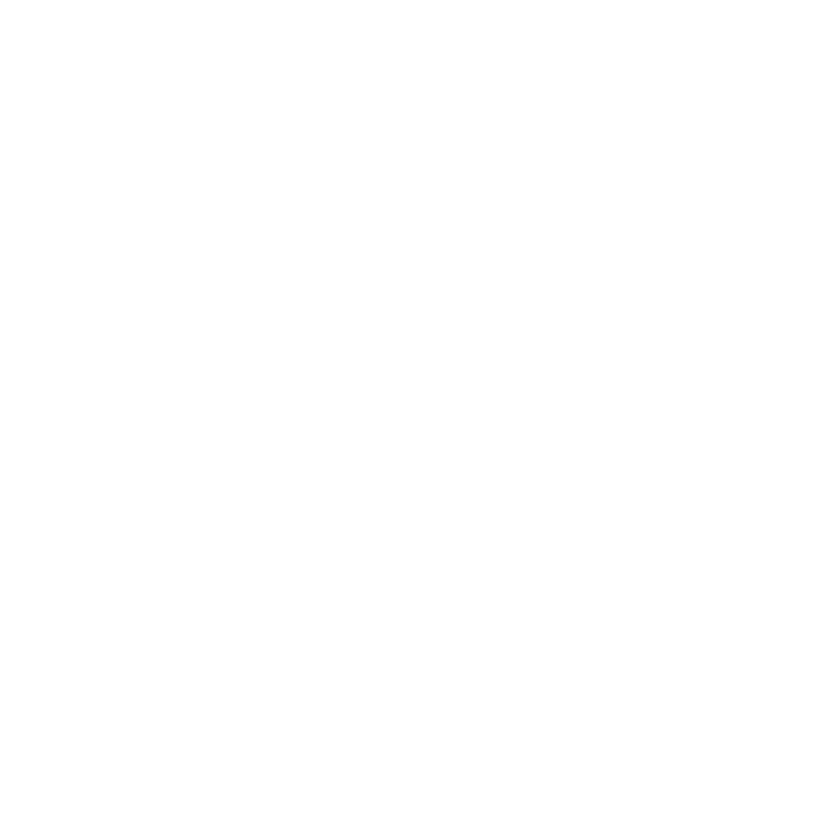

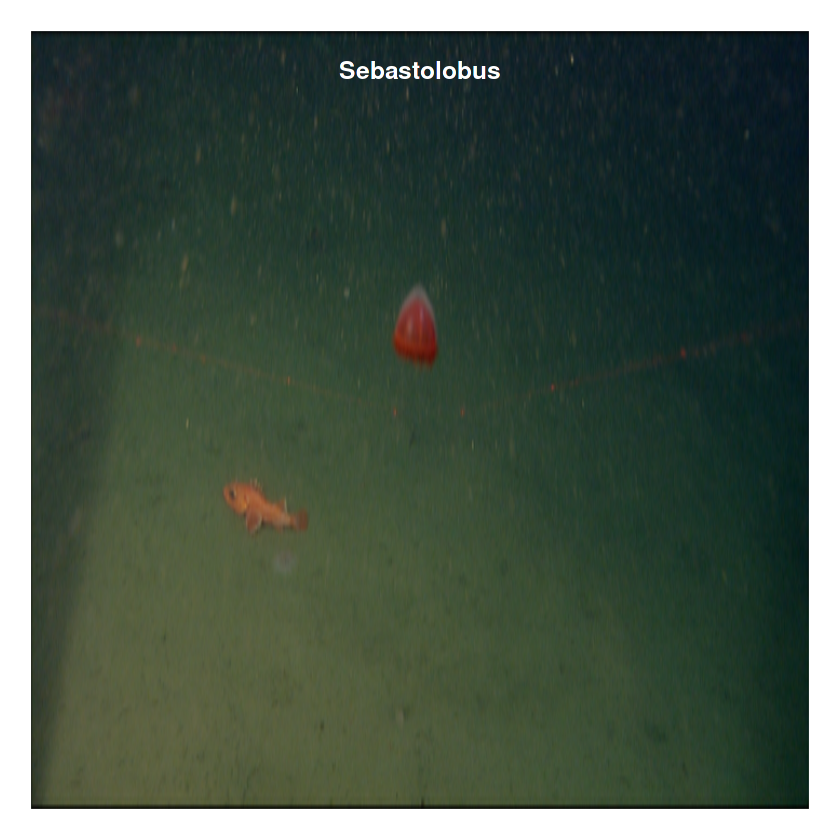

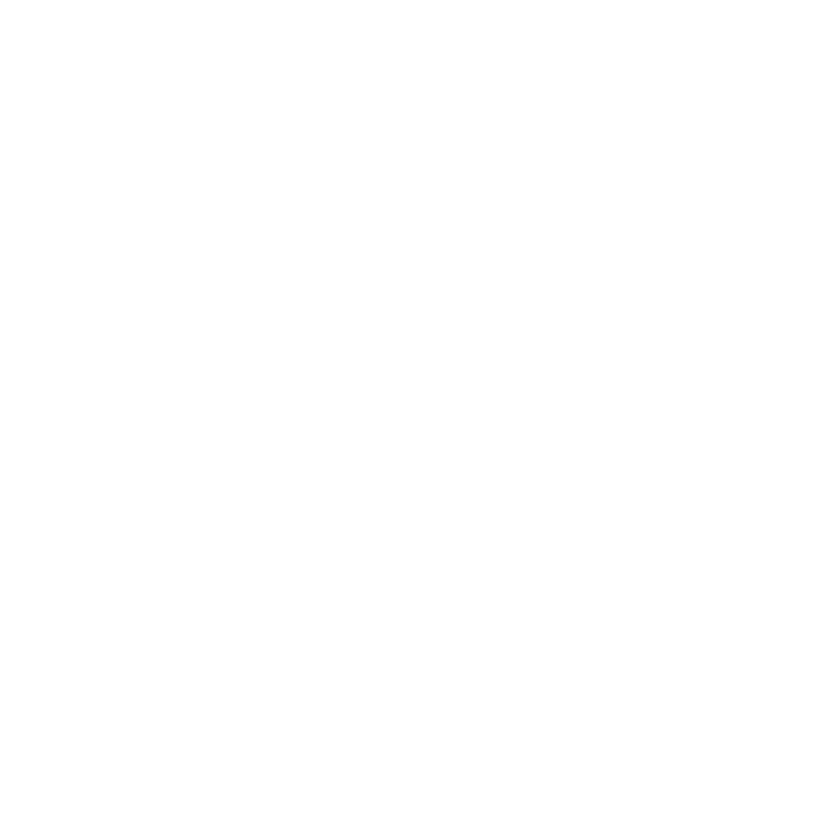

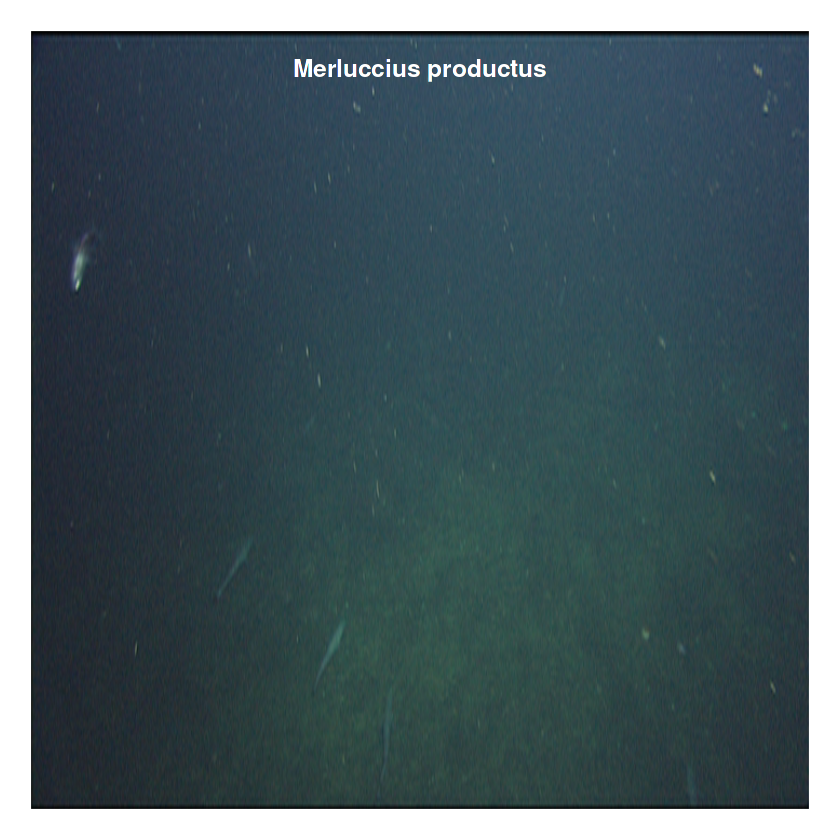

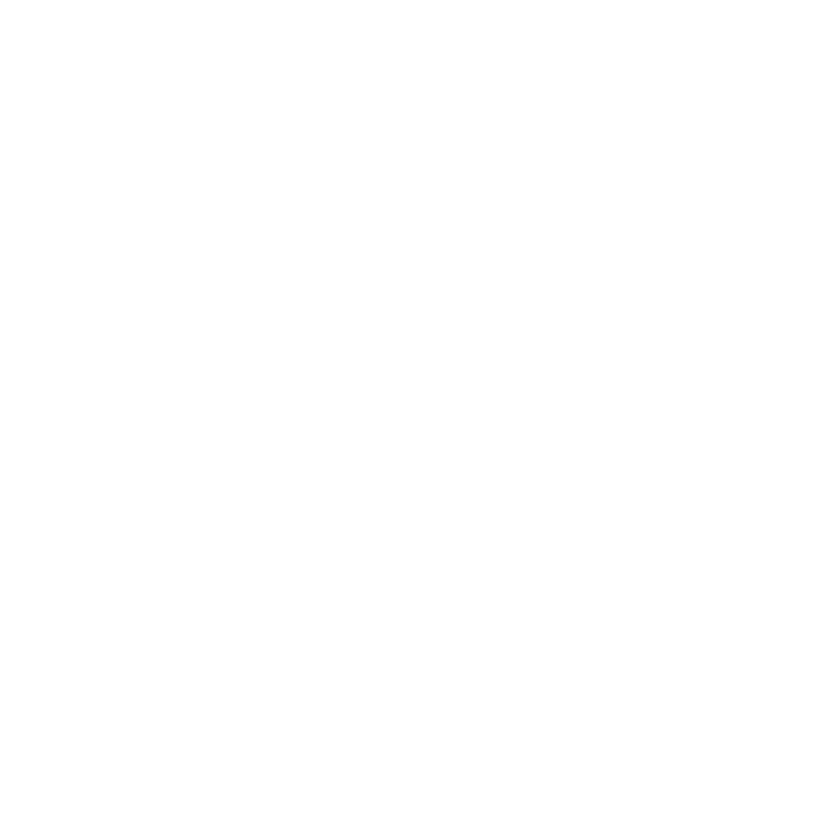

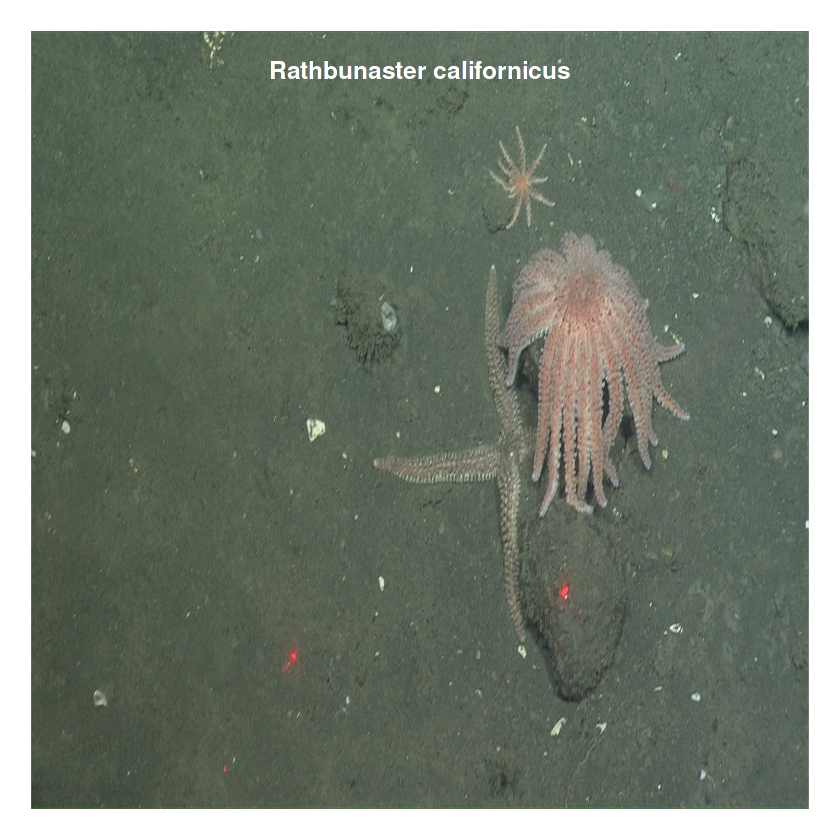

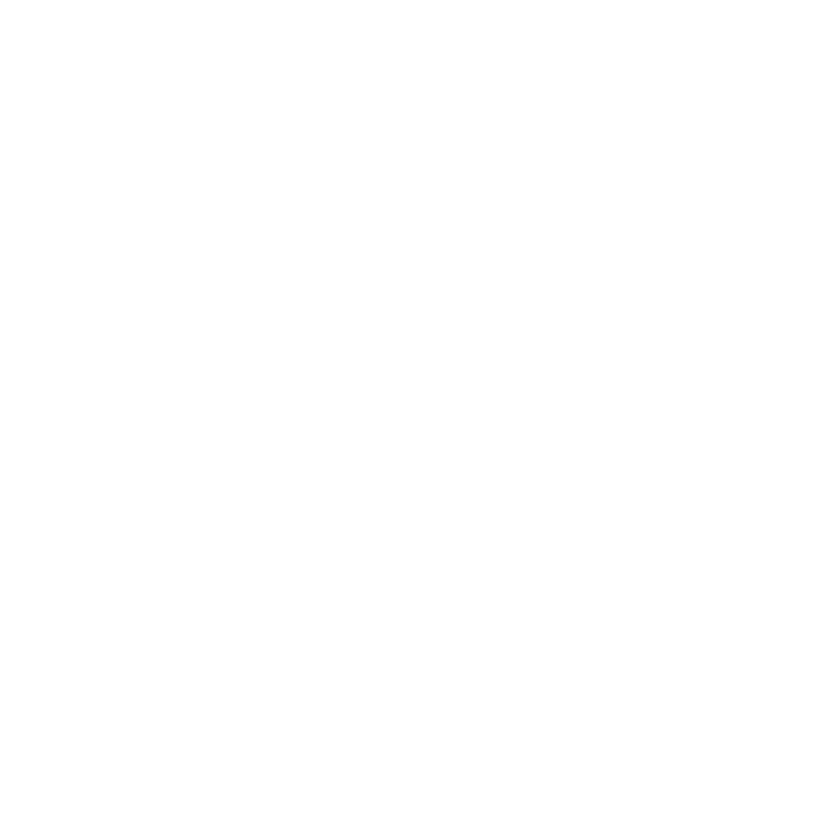

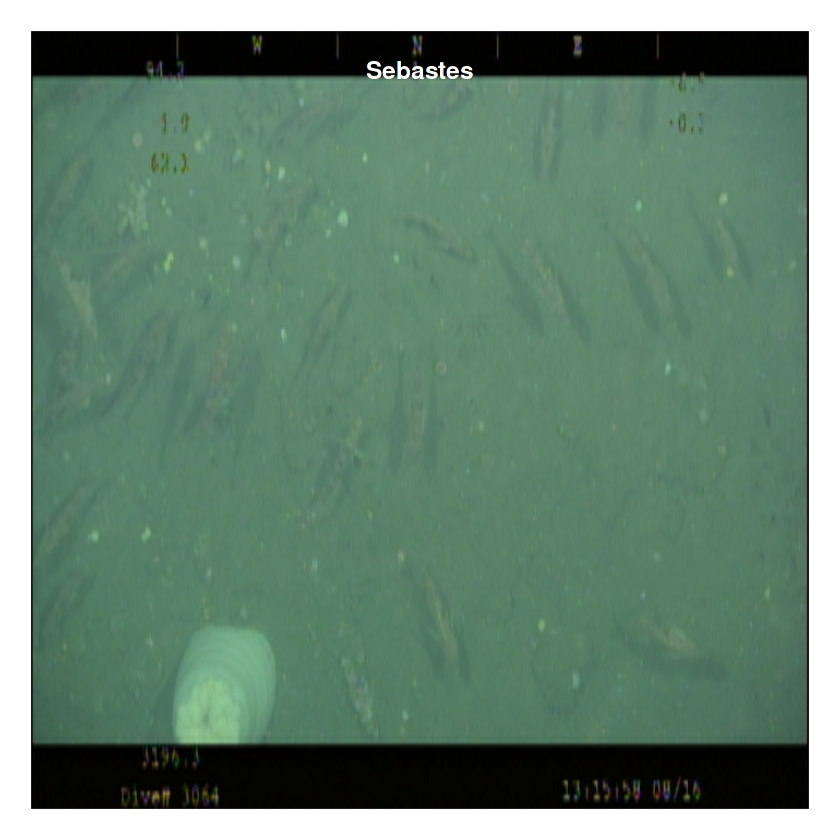

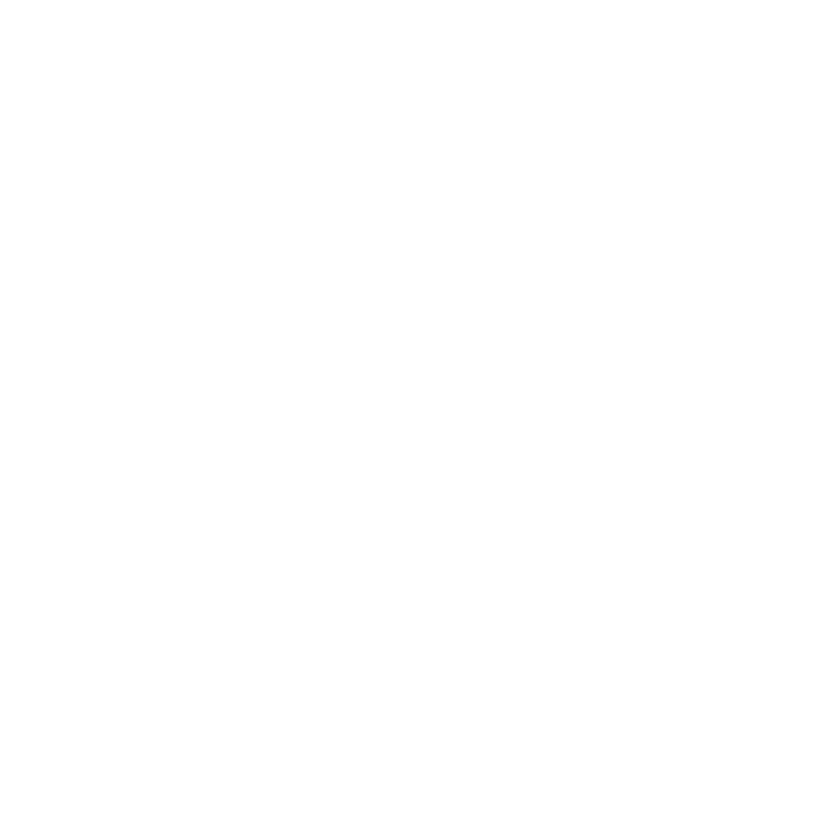

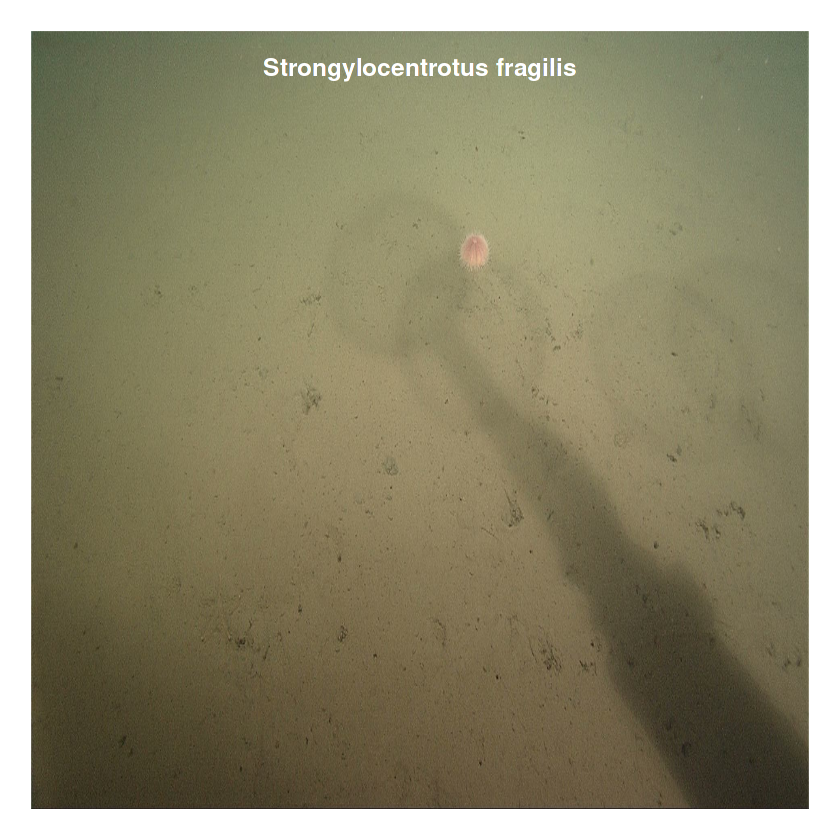

In [124]:
save_path <- "/kaggle/working/exploration"
unlink(save_path, recursive = TRUE)
dir.create(save_path)

#download and display images of these species
label_to_id_dict <- setNames(key$id, key$name)
top_10_label_list <- as.character(top_10$label_list)
image_path_list <- c()
for (i in 1:length(top_10_label_list)) {
    label <- top_10_label_list[[i]]
    id <- label_to_id_dict[label]
    image_url <- find_url_of_image_containing_id(id, training_data_merged)
    image_path = here(save_path, paste(label,".png", sep = ""))
    download_images(image_url, image_path)
    image_path_list <- c(image_path_list, image_path)
}

display_images(image_path_list,top_10_label_list)

Baseline Bounding Box Detection with YoloV3

In [ ]:
remotes::install_github("maju116/platypus")

pillar   (1.8.1     -> 1.9.0    ) [CRAN]
vctrs    (0.5.2     -> 0.6.1    ) [CRAN]
tibble   (3.1.8     -> 3.2.1    ) [CRAN]
rlang    (1.0.6     -> 1.1.0    ) [CRAN]
hms      (1.1.2     -> 1.1.3    ) [CRAN]
cli      (3.6.0     -> 3.6.1    ) [CRAN]
ps       (1.7.2     -> 1.7.5    ) [CRAN]
processx (3.8.0     -> 3.8.1    ) [CRAN]
gtable   (0.3.1     -> 0.3.3    ) [CRAN]
XML      (3.99-0.13 -> 3.99-0.14) [CRAN]
ggplot2  (3.4.1     -> 3.4.2    ) [CRAN]
dplyr    (1.1.0     -> 1.1.1    ) [CRAN]
keras    (2.6.0     -> 2.11.1   ) [CRAN]


Installing 13 packages: pillar, vctrs, tibble, rlang, hms, cli, ps, processx, gtable, XML, ggplot2, dplyr, keras

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Warning message in i.p(...):
“installation of package ‘rlang’ had non-zero exit status”
Warning message in i.p(...):
“installation of package ‘cli’ had non-zero exit status”
